In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from sklearn.decomposition import PCA, FastICA
import funciones_4 as fn4  # Funciones de utilidad (match_len, snr, sisdr, ensure_mono)

# ===============================
# PARAMETERS
# ===============================
fs = 48000  # Sample rate
n_sources = 3

# ===============================
# LOAD RECORDINGS
# ===============================
audio_files_ses1 = [
    "audio_sesion1/nicolas_01.wav",
    "audio_sesion1/soleil_01.wav",
    "audio_sesion1/cristo_01.wav"
]

audio_files_ses2 = [
    "audio_sesion2/nicolas_02.wav",
    "audio_sesion2/soleil_02.wav",
    "audio_sesion2/cristo_02.wav"
]

In [2]:
# Load and ensure mono
def load_mono(files):
    audios = []
    for f in files:
        x, fs_file = sf.read(f)
        x = fn4.ensure_mono(x)
        audios.append(x)
    min_len = min([len(a) for a in audios])
    audios = [a[:min_len] for a in audios]
    return np.column_stack(audios), fs_file

X_train, fs_train = load_mono(audio_files_ses1)
X_val, fs_val = load_mono(audio_files_ses2)

print("Training mixture shape:", X_train.shape)
print("Validation mixture shape:", X_val.shape)

Training mixture shape: (2165291, 3)
Validation mixture shape: (2223813, 3)


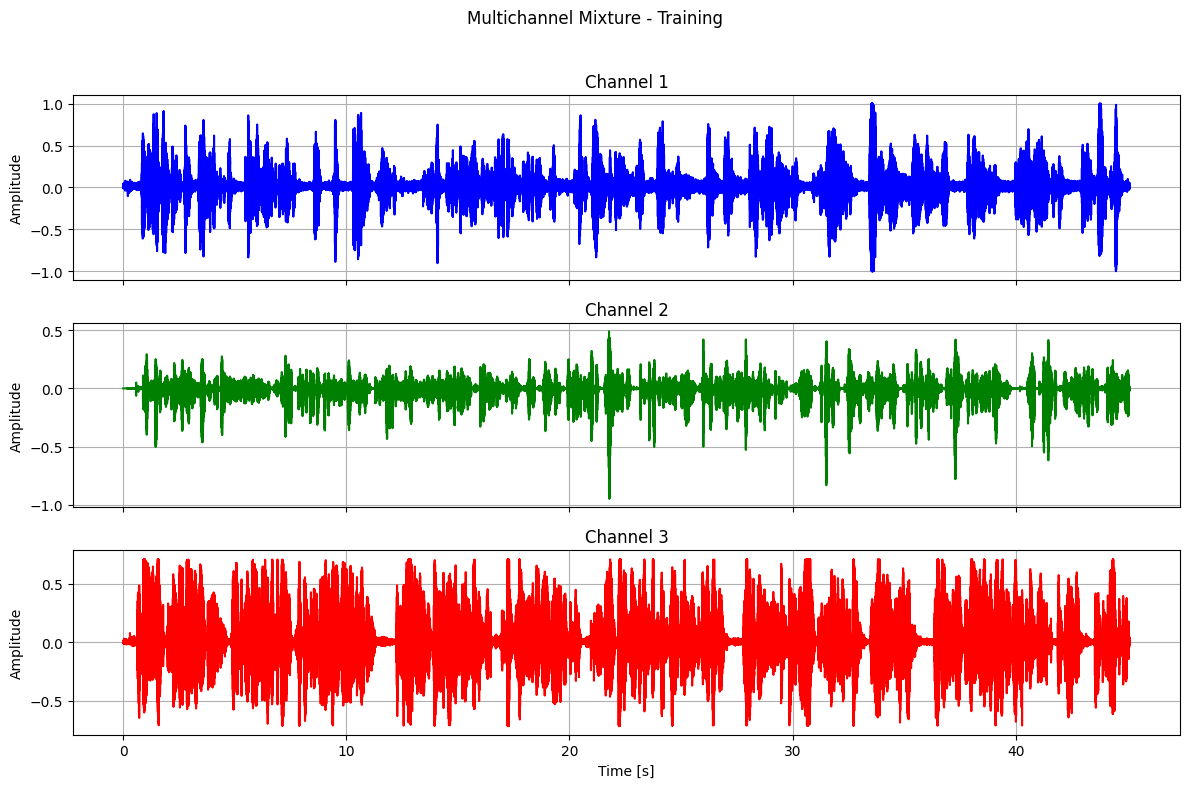

In [3]:
# ===============================
# PLOT ORIGINAL MIXTURES (TRAINING)
# ===============================
t_train = np.arange(X_train.shape[0]) / fs
fig, axes = plt.subplots(n_sources, 1, figsize=(12, 8), sharex=True)
colors = ['blue', 'green', 'red']
for i in range(n_sources):
    axes[i].plot(t_train, X_train[:,i], color=colors[i])
    axes[i].set_ylabel("Amplitude")
    axes[i].set_title(f"Channel {i+1}")
    axes[i].grid(True)
axes[-1].set_xlabel("Time [s]")
plt.suptitle("Multichannel Mixture - Training")
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


In [4]:
# ===============================
# ICA PREPROCESSING: CENTERING + WHITENING
# ===============================
X_centered = X_train - X_train.mean(axis=0)
pca = PCA(whiten=True)
X_white = pca.fit_transform(X_centered)

In [5]:
# ===============================
# FASTICA TRAINING
# ===============================
ica = FastICA(n_components=n_sources, random_state=42)
S_est = ica.fit_transform(X_white)
W = ica.components_

# Normalize to [-1, 1] to avoid saturation
S_norm = S_est / np.max(np.abs(S_est), axis=0)

# Save separated sources
for i in range(n_sources):
    sf.write(f"audio_result/source{i+1}_estimated.wav", S_norm[:,i], fs)


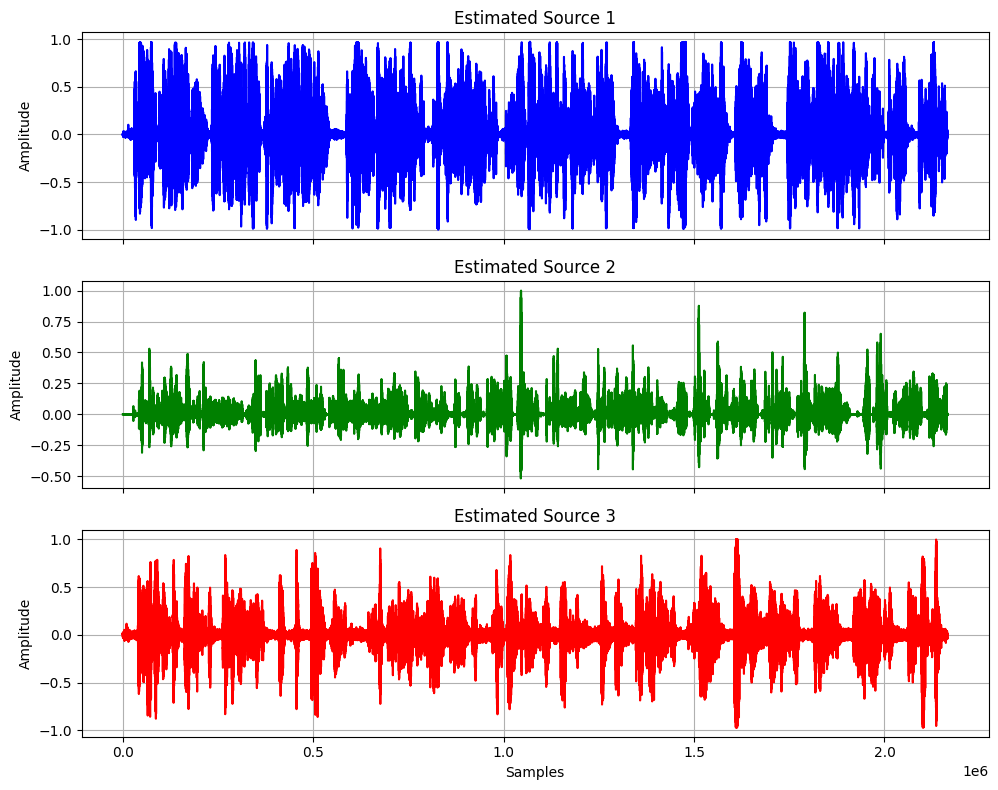

In [6]:
# ===============================
# PLOT SEPARATED SOURCES (TRAINING)
# ===============================
fig, axes = plt.subplots(n_sources, 1, figsize=(10, 8), sharex=True)
for i in range(n_sources):
    axes[i].plot(S_norm[:,i], color=colors[i])
    axes[i].set_ylabel("Amplitude")
    axes[i].set_title(f"Estimated Source {i+1}")
    axes[i].grid(True)
axes[-1].set_xlabel("Samples")
plt.tight_layout()
plt.show()



In [7]:
# ===============================
# METRICS TRAINING
# ===============================
refs = [X_train[:,i] for i in range(n_sources)]
ests = [S_norm[:,i] for i in range(n_sources)]

print("\n===== METRICS: TRAINING =====")
for i in range(n_sources):
    ref, est = fn4.match_len(refs[i], ests[i])
    print(f"\nSource {i+1}:")
    print(" Correlation =", np.corrcoef(ref, est)[0,1])
    print(" SNR =", fn4.snr(ref, est), "dB")
    print(" SI-SDR =", fn4.sisdr(ref, est), "dB")


===== METRICS: TRAINING =====

Source 1:
 Correlation = 0.0024832145700700386
 SNR = -5.211367471496552 dB
 SI-SDR = -52.16126995270897 dB

Source 2:
 Correlation = -0.9999954379813325
 SNR = -6.247521171118101 dB
 SI-SDR = 50.12600067475428 dB

Source 3:
 Correlation = -0.0047291390510388175
 SNR = -2.522882229156616 dB
 SI-SDR = -46.51052389872659 dB


In [8]:
# ===============================
# VALIDATION USING SAME W
# ===============================
# Center with training mean
X_val_centered = X_val - X_val.mean(axis=0)

# Whitening using PCA from training
X_val_white = pca.transform(X_val_centered)

# Apply separation matrix W
S_val_est = (W @ X_val_white.T).T

# Normalize to [-1,1]
S_val_norm = S_val_est / np.max(np.abs(S_val_est), axis=0)

# Save validation sources
for i in range(n_sources):
    sf.write(f"audio_result/source{i+1}_validation.wav", S_val_norm[:,i], fs)


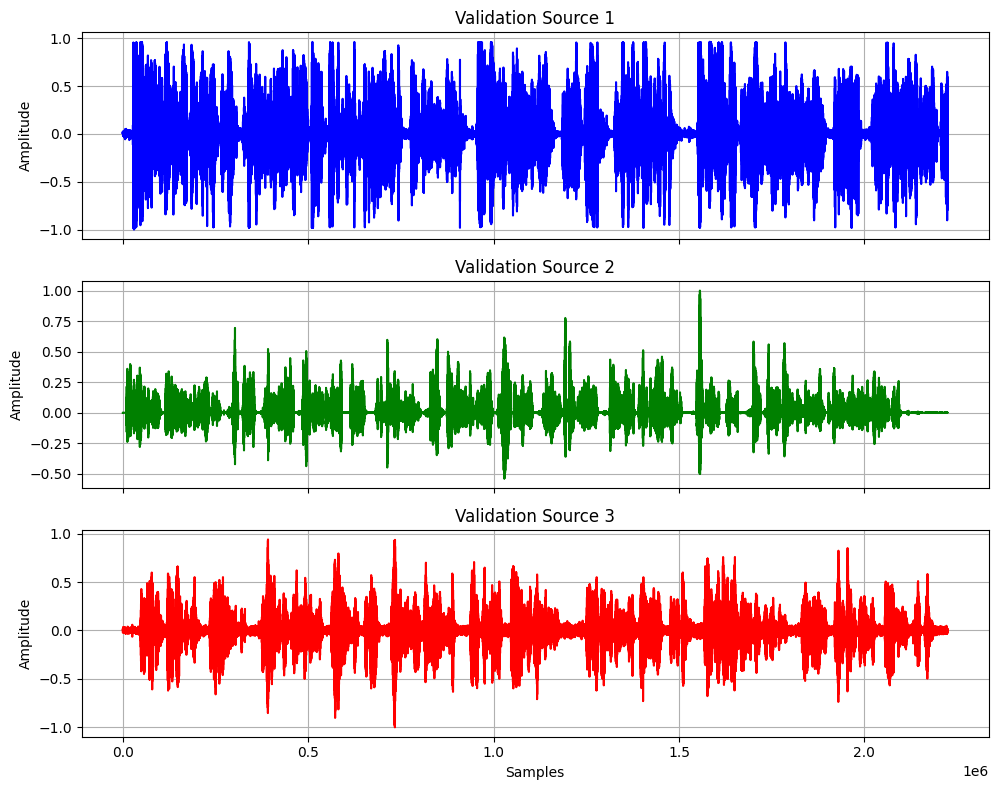

In [9]:
# ===============================
# PLOT VALIDATION SOURCES
# ===============================
fig, axes = plt.subplots(n_sources, 1, figsize=(10, 8), sharex=True)
for i in range(n_sources):
    axes[i].plot(S_val_norm[:,i], color=colors[i])
    axes[i].set_ylabel("Amplitude")
    axes[i].set_title(f"Validation Source {i+1}")
    axes[i].grid(True)
axes[-1].set_xlabel("Samples")
plt.tight_layout()
plt.show()


In [10]:
# ===============================
# METRICS VALIDATION
# ===============================
refs_val = [X_val[:,i] for i in range(n_sources)]
ests_val = [S_val_norm[:,i] for i in range(n_sources)]

print("\n===== METRICS: VALIDATION =====")
for i in range(n_sources):
    ref, est = fn4.match_len(refs_val[i], ests_val[i])
    print(f"\nSource {i+1}:")
    print(" Correlation =", np.corrcoef(ref, est)[0,1])
    print(" SNR =", fn4.snr(ref, est), "dB")
    print(" SI-SDR =", fn4.sisdr(ref, est), "dB")



===== METRICS: VALIDATION =====

Source 1:
 Correlation = 0.00536649815564958
 SNR = -8.211794804889236 dB
 SI-SDR = -45.44889073701362 dB

Source 2:
 Correlation = -0.9999979730548675
 SNR = -6.057149900934574 dB
 SI-SDR = 53.402616760307914 dB

Source 3:
 Correlation = -0.00448165821163691
 SNR = -2.1715122338948922 dB
 SI-SDR = -46.97816779124986 dB
